<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/9x.ml_highspeed_networks/1.Training-and-testing-a-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import pickle # To save the model
from functools import partial
import random



# The following is to be able to mount Google Drive
from google.colab import drive


# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


from typing import List

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


import os
from os.path import isfile

--2022-02-14 09:48:57--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0s      

2022-02-14 09:48:57 (107 MB/s) - ‘visualization.py’ saved [13008/13008]



# Download the dataset and train/test split

Load the dataset

In [2]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/fulldataset.csv


--2022-02-14 09:49:12--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261162 (255K) [text/plain]
Saving to: ‘lowdataset.csv’

lowdataset.csv      100%[===================>] 255.04K  --.-KB/s    in 0.02s   

2022-02-14 09:49:13 (11.7 MB/s) - ‘lowdataset.csv’ saved [261162/261162]

--2022-02-14 09:49:13--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443

In [3]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time"])

data = full_df.to_numpy()
print (data)

[[1.83684800e+06 1.90327023e+08 1.16151881e+08 ... 2.59473178e+08
  1.00265909e+02 0.00000000e+00]
 [1.85564100e+06 1.90782590e+08 1.16159726e+08 ... 2.59522865e+08
  1.00276024e+02 0.00000000e+00]
 [1.85637300e+06 1.90688064e+08 1.16229597e+08 ... 2.59533231e+08
  1.00281822e+02 0.00000000e+00]
 ...
 [4.63221500e+06 1.75145145e+08 9.35510160e+07 ... 2.59453245e+08
  1.00262788e+02 2.00000000e+00]
 [4.64478900e+06 1.75105471e+08 9.33248380e+07 ... 2.59444187e+08
  1.00259509e+02 2.00000000e+00]
 [4.63646600e+06 1.75154689e+08 9.35143800e+07 ... 2.59458785e+08
  1.00264199e+02 2.00000000e+00]]


In [4]:
full_df.head()

,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,LLC-load-misses,LLC-loads,LLC-store-misses,LLC-stores,branch-load-misses,branch-misses,branches,bus-cycles,cache-misses,cache-references,context-switches,cpu-clock,cycles,dTLB-load-misses,dTLB-store-misses,dTLB-stores,iTLB-load-misses,iTLB-loads,instructions,minor-faults,node-load-misses,node-loads,node-store-misses,node-stores,page-faults,ref-cycles,task-clock,label
0,1836848.0,190327023.0,116151881.0,31680.0,301.0,272831.0,251.0,155393.0,171640.0,172007.0,105852681.0,9979685.0,597.0,450842.0,0.0,100.265610,259323485.0,1930.0,1003.0,116268401.0,2595.0,8.0,614259959.0,0.0,169.0,150.0,50.0,213.0,0.0,259473178.0,100.265909,0
1,1855641.0,190782590.0,116159726.0,31550.0,288.0,273045.0,259.0,154536.0,173760.0,173161.0,105824138.0,9979835.0,602.0,454711.0,0.0,100.276363,259527811.0,1968.0,1028.0,116231409.0,2557.0,0.0,614006400.0,0.0,175.0,125.0,50.0,238.0,0.0,259522865.0,100.276024,0
2,1856373.0,190688064.0,116229597.0,30507.0,251.0,272370.0,251.0,154825.0,170987.0,170923.0,105932173.0,9980286.0,657.0,451996.0,0.0,100.282061,259493612.0,1981.0,1040.0,116288889.0,2595.0,8.0,614749577.0,0.0,257.0,94.0,25.0,213.0,0.0,259533231.0,100.281822,0
3,1855415.0,190785345.0,116289893.0,32535.0,226.0,273049.0,251.0,154438.0,170998.0,170960.0,105974902.0,9983166.0,1374.0,454628.0,0.0,100.269016,259464166.0,2031.0,1015.0,116218953.0,2645.0,0.0,614927834.0,0.0,157.0,138.0,13.0,226.0,0.0,259571508.0,100.270504,0
4,1844978.0,190653473.0,116246239.0,31360.0,363.0,270856.0,259.0,154519.0,172861.0,172986.0,105931477.0,9978938.0,1325.0,452995.0,0.0,100.271755,259535337.0,2018.0,978.0,116317169.0,2914.0,0.0,614366676.0,0.0,263.0,489.0,50.0,238.0,0.0,259490859.0,100.270495,0


In [5]:
print("samples and columns", full_df.shape)
print("Possible labels ", np.unique(full_df['label']) )

samples and columns (5824, 32)
Possible labels  [0 1 2]


In [6]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=1 )

# Pre-processing

In [7]:
# We separate the last column in 
train_x, train_y = np.hsplit(train, [train.shape[1] - 1])
train_y = train_y.reshape(-1).astype(int)

test_x, test_y = np.hsplit(test, [test.shape[1] - 1])
test_y = test_y.reshape(-1).astype(int)

We apply Min-Max scaler. In this code we do it by hand, but we could have done it also by directly using `sklearn.preprocessing.MinMaxScaler`.

In [8]:
min = train_x.min(axis=0)
max = train_x.max(axis=0)

train_x = (train_x - min)/(max - min)
test_x = (test_x - min)/(max - min)

# Google Drive

Use the following code (modify it with the names of your folders) to attach your google drive, where you will store your models, to be used later in the testbed notebook.

In [9]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/09.highspeed-net/'

Mounted at /content/gdrive


# Logistic Regression

Normalized confusion matrix
[[0.99469496 0.00265252 0.00265252]
 [0.23446328 0.72033898 0.04519774]
 [0.08986175 0.1843318  0.72580645]]
The accuracy is  0.8111587982832618


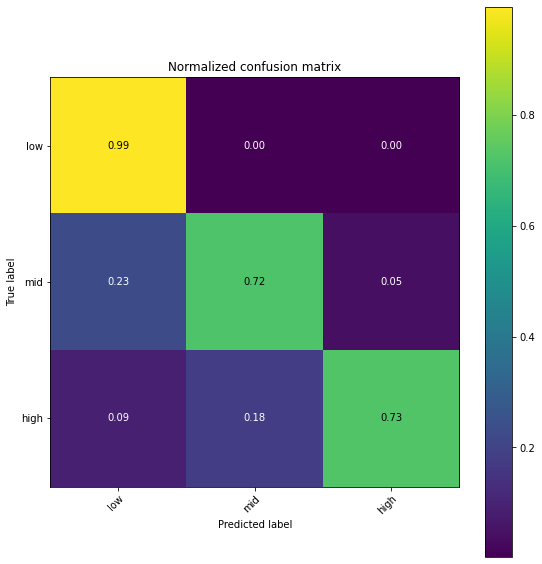

In [10]:
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=600)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
class_names = np.array(["low", "mid", "high"] )
plot_conf_mat(test_y, y_pred, class_names)
print("The accuracy is ", accuracy_score(test_y, y_pred) )

Save the model

In [11]:
with open(my_path+"logistic-reg.pkl", "wb") as dump_file:
  pickle.dump(model, dump_file)

# 1st Neural Network

If you use Neural Networks, in Colab do "Runtime > Change Runtime type" to TPU or GPU.

The functions `build_model()` and `train_model(..)` are very similar to what you encountered in the [notebooks on Neural Networks](https://github.com/andreaaraldo/machine-learning-for-networks/tree/master/04.neural_networks).

In [12]:
def make_sequential_model(sample_size, layer_sizes, 
                          hidden_activation_function="relu", 
                          out_activation_function="softmax",
                          loss_fun="sparse_categorical_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 5 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of 
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()


  # In the next code we will use `partial`, which is a function of the ptyhon
  # library functools, which allows to define a class, identical to another
  # class but with some different default values.
  # In our case we define MyDenseLayer equal to the standard keras class
  # `Dense`, which implements a simple neural network layer, specifying 
  # two default values: one for the activation function, and another for the
  # regularization

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0], 
                  input_dim = sample_size) )
  
  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )
    
  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )
  

  model.compile(loss=loss_fun, 
              optimizer=keras.optimizers.Adam(lr=learning_rate) ,
              metrics=metrics)
  
  return model


def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more: 
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))


def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000, 
                overwrite=True, validation_split=0.2, patience=20):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training 
            (thanks to the ModelCheckpoint callback (see the implementation 
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.
  
  overwrite: boolean
            If true, the model will be built and trained from scratch, 
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the 
            specified number of epochs
  """
  
  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor 
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the 
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of 
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True) 


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs, 
                      callbacks = [plot_cb, checkpoint_cb, logger_cb, early_stop_cb], 
                      validation_split=validation_split )

  return history

In [13]:
sample_size = train_x.shape[1]
num_of_classes=len(class_names)

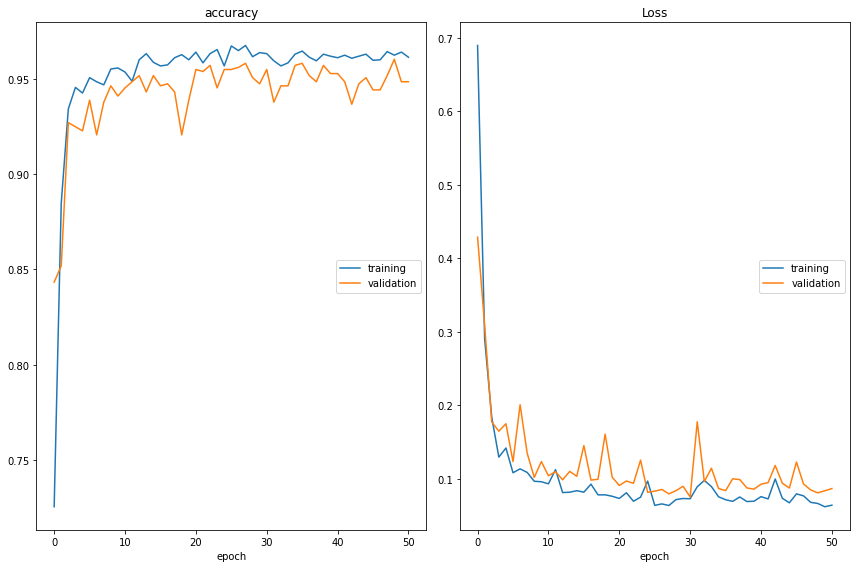

accuracy
	training         	 (min:    0.726, max:    0.968, cur:    0.961)
	validation       	 (min:    0.843, max:    0.960, cur:    0.948)
Loss
	training         	 (min:    0.062, max:    0.690, cur:    0.064)
	validation       	 (min:    0.075, max:    0.429, cur:    0.087)
Restoring model weights from the end of the best epoch: 31.
117/117 [==============================] - 1s 6ms/step - loss: 0.0642 - accuracy: 0.9614 - val_loss: 0.0868 - val_accuracy: 0.9485
Epoch 00051: early stopping


In [14]:
nnfile = nn_file = my_path + 'nn1.h5'

shallow_architecture=[20, 10, 5, num_of_classes]
model = make_sequential_model(sample_size, shallow_architecture)
history = train_model(model, nn_file, train_x, train_y, seed=3)

In [15]:
print("The trained NN model has been saved to ", nnfile)

The trained NN model has been saved to  /content/gdrive/My Drive/tsp/teaching/data-science-for-networks/img-from-code/09.highspeed-net/nn1.h5


Normalized confusion matrix
[[0.9867374  0.00530504 0.00795756]
 [0.05649718 0.93785311 0.00564972]
 [0.06682028 0.01152074 0.92165899]]
The accuracy is  0.9476394849785408


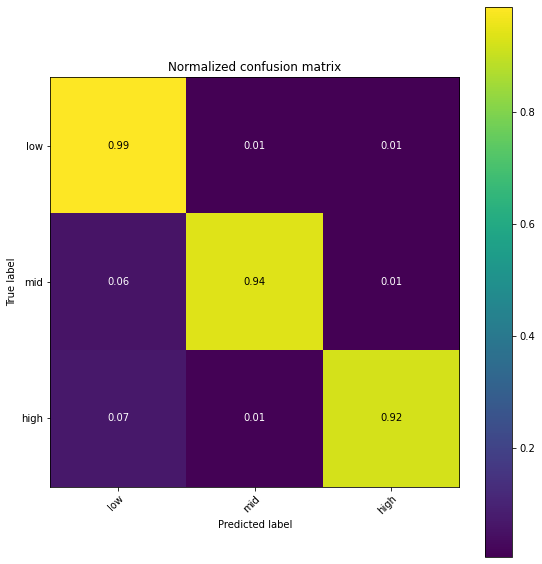

In [20]:
y_pred_ = model.predict(test_x)
y_pred = np.argmax(y_pred_, axis=1)
plot_conf_mat(test_y, y_pred, class_names)
print("The accuracy is ", accuracy_score(test_y, y_pred) )

This NN performs better than the Logistic Regression. However, will it be fast enough to classify at line speed?

You will have to check on the testbed notebook!

# Your model

Train your models here and dump (i.e., save) them.